In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import TFViTModel, ViTFeatureExtractor

from tensorflow.keras.utils import register_keras_serializable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing import image
from PIL import Image

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 5
VALIDATION_SPLIT = 0.2
SEED = 123

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model.trainable = False

train_dir = r"..\Dataset\Balanced_Train"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True
)

def preprocess_batch(images, labels):
    images = tf.cast(images, tf.uint8)

    def extract(imgs):
        imgs = imgs.numpy()
        out = feature_extractor(images=list(imgs), return_tensors="tf")["pixel_values"]
        return out

    images = tf.py_function(func=extract, inp=[images], Tout=tf.float32)
    images.set_shape((None, 3, IMG_HEIGHT, IMG_WIDTH))
    images = tf.transpose(images, [0, 2, 3, 1]) 
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

d:\Anaconda\envs\dl_py\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\Anaconda\envs\dl_py\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Found 31155 files belonging to 5 classes.
Using 24924 files for training.
Found 31155 files belonging to 5 classes.
Using 6231 files for validation.


In [ ]:
class ViTWrapper(tf.keras.layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super().__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, x):
        x = tf.transpose(x, [0, 3, 1, 2])  
        return self.vit_model(pixel_values=x).last_hidden_state[:, 0, :] 

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(vit_model=None, **config)

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = ViTWrapper(vit_model)(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adamW', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(r"..\Model\ViT_B16.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
]

model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)


Epoch 1/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9109 - loss: 0.2843
Epoch 1: val_accuracy improved from -inf to 0.97127, saving model to vit_final.keras
779/779 ━━━━━━━━━━━━━━━━━━━━ 594s 731ms/step - accuracy: 0.9110 - loss: 0.2841 - val_accuracy: 0.9713 - val_loss: 0.0965
Epoch 2/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.9721 - loss: 0.0866
Epoch 2: val_accuracy improved from 0.97127 to 0.97930, saving model to vit_final.keras
779/779 ━━━━━━━━━━━━━━━━━━━━ 565s 725ms/step - accuracy: 0.9721 - loss: 0.0865 - val_accuracy: 0.9793 - val_loss: 0.0670
Epoch 3/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9759 - loss: 0.0725
Epoch 3: val_accuracy improved from 0.97930 to 0.97962, saving model to vit_final.keras
779/779 ━━━━━━━━━━━━━━━━━━━━ 556s 712ms/step - accuracy: 0.9759 - loss: 0.0725 - val_accuracy: 0.9796 - val_loss: 0.0602
Epoch 4/50
779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9789 - loss: 0.0596
Epoch 4: val_accuracy im

In [6]:
@register_keras_serializable()
class ViTWrapper(tf.keras.layers.Layer):
    def __init__(self, vit_model=None, **kwargs):
        super().__init__(**kwargs)
        if vit_model is None:
            self.vit = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        else:
            self.vit = vit_model

    def call(self, x):
        x = tf.transpose(x, [0, 3, 1, 2])  
        return self.vit(pixel_values=x).last_hidden_state[:, 0, :]  

    def get_config(self):
        config = super().get_config()
        return config

model = tf.keras.models.load_model(r"..\Model\ViT_B16.keras", custom_objects={"ViTWrapper": ViTWrapper})

model.summary()


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_wrapper_5 (ViTWrapper)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,137 (582.57 KB)

 Trainable params: 49,669 (194.02 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 99,340 (388.05 KB)

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

test_dir = r'..\Dataset\Test'

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False  
)

class_names = raw_test_ds.class_names
test_ds = raw_test_ds.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 4339 files belonging to 5 classes.


136/136 ━━━━━━━━━━━━━━━━━━━━ 73s 526ms/step
✅ Test Accuracy: 0.9620


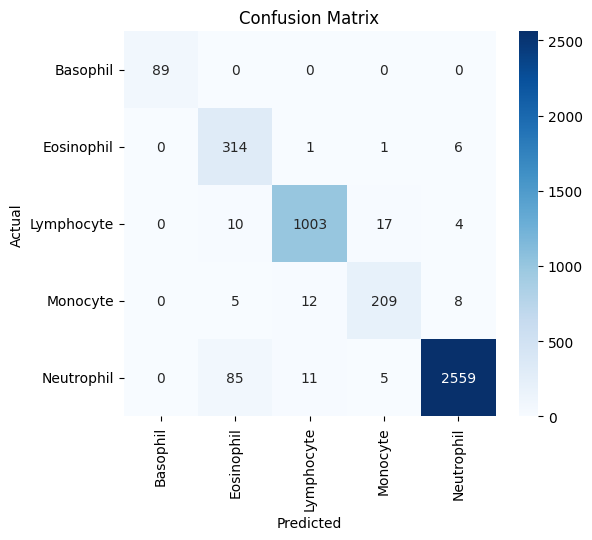

📊 Classification Report:
              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.76      0.98      0.85       322
  Lymphocyte       0.98      0.97      0.97      1034
    Monocyte       0.90      0.89      0.90       234
  Neutrophil       0.99      0.96      0.98      2660

    accuracy                           0.96      4339
   macro avg       0.93      0.96      0.94      4339
weighted avg       0.97      0.96      0.96      4339



In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)
y_true = np.argmax(y_true, axis=1)

acc = accuracy_score(y_true, y_pred_classes)
print(f"✅ Test Accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


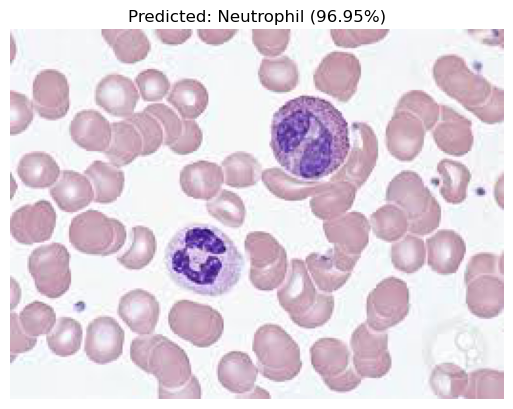

Predicted Class: Neutrophil


In [ ]:
class_names = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
def predict_image_class(img_path):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))

    inputs = feature_extractor(images=img_resized, return_tensors="tf")
    pixel_values = inputs['pixel_values'] 

    pixel_values = tf.transpose(pixel_values, [0, 2, 3, 1]) 

    # Predict
    predictions = model.predict(pixel_values)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Plot result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

    return predicted_class

img_path = r"C:\Users\dell\Downloads\Neutrophil.jpeg"
predicted_class = predict_image_class(img_path)
print(f"Predicted Class: {predicted_class}")
